In [20]:
import torch
from torch import autograd
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
from kan import KAN, LBFGS

device = torch.device("cpu")
print("Using device:", device)

rho = torch.tensor(1.0, device=device, requires_grad=False)
nu = torch.tensor(0.01, device=device, requires_grad=False)
eps = torch.tensor(1e-8, device=device, requires_grad=False)

width, height = 10.0, 2.0
num_points_x, num_points_y = 100, 20

x = torch.linspace(0, width, num_points_x, device=device, requires_grad=False)
y = torch.linspace(0, height, num_points_y, device=device, requires_grad=False)
X, Y = torch.meshgrid(x, y, indexing='ij')
coordinates = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
coordinates.requires_grad = True  # Ensure coordinates require grad

model = KAN(width=[2,3,3, 3], grid=5, k=10, grid_eps=1.0,
            noise_scale_base=0.25).to(device)

def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

def batch_hessian(func, x):
    jacobian = batch_jacobian(func, x, create_graph=True)
    hessians = []
    for i in range(jacobian.size(1)):
        grad = autograd.grad(jacobian[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
        hessians.append(grad.unsqueeze(1))
    return torch.cat(hessians, dim=1)

def navier_stokes_residuals(coords):
    coords = coords.clone().detach().requires_grad_(True)  # Ensure coords require grad
    y_pred = model(coords)
    grads = batch_jacobian(model, coords, create_graph=True)
    hessians = batch_hessian(model, coords)

    u, v, p = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    u_x, u_y = grads[:, 0, 0], grads[:, 0, 1]
    v_x, v_y = grads[:, 1, 0], grads[:, 1, 1]
    p_x, p_y = grads[:, 2, 0], grads[:, 2, 1]

    u_xx, u_yy = hessians[:, 0, 0], hessians[:, 0, 1]
    v_xx, v_yy = hessians[:, 1, 0], hessians[:, 1, 1]

    continuity = u_x + v_y + eps * p
    x_momentum = u * u_x + v * u_y + (1 / rho) * p_x - nu * (u_xx + u_yy)
    y_momentum = u * v_x + v * v_y + (1 / rho) * p_y - nu * (v_xx + v_yy)

    no_slip_mask = (coords[:, 1] == 0) | (coords[:, 1] == height)
    inlet_mask = (coords[:, 0] == 0)
    outlet_mask = (coords[:, 0] == width)

    no_slip_loss = torch.mean(u[no_slip_mask] ** 2 + v[no_slip_mask] ** 2)
    inlet_loss = torch.mean((u[inlet_mask] - 1) ** 2)
    outlet_pressure_loss = torch.mean(p[outlet_mask] ** 2)

    bc_loss = no_slip_loss + inlet_loss + outlet_pressure_loss
    total_loss = torch.mean(continuity ** 2 + x_momentum ** 2 + y_momentum ** 2) + bc_loss
    return total_loss

writer = SummaryWriter()

def train():
    optimizer = LBFGS(model.parameters(), lr=1,
                      history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    
    steps = 200 # 20 steps are enough
    pbar = tqdm(range(steps), desc='Training Progress')

    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = navier_stokes_residuals(coordinates)
            loss.backward()
            return loss

        optimizer.step(closure)
        if step % 5 == 0:
            current_loss = closure().item()
            pbar.set_description("Step: %d | Loss: %.3f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)

train()

writer.close()


Using device: cpu


Step: 195 | Loss: 0.011: 100%|██████████| 200/200 [2:52:51<00:00, 51.86s/it]  


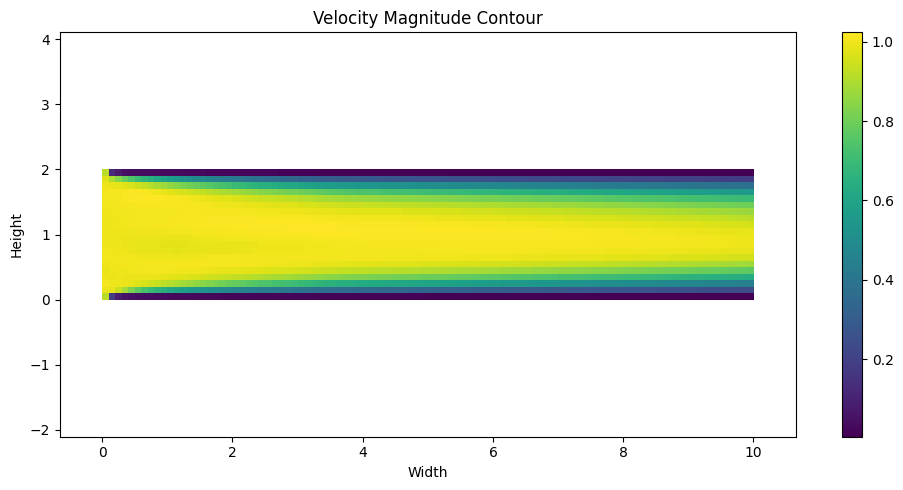

In [24]:
u_pred = model(coordinates)[:, 0].detach().reshape(
    num_points_x, num_points_y).T

v_pred = model(coordinates)[:, 1].detach().reshape(
    num_points_x, num_points_y).T


magnitude = torch.sqrt(u_pred ** 2 + v_pred ** 2)

plt.figure(figsize=(10, 5))  # Set the figure size as needed
plt.imshow(magnitude, extent=(0, width, 0, height), origin='lower', cmap='viridis')
plt.colorbar()  # Add a colorbar to show the magnitude scale
plt.title('Velocity Magnitude Contour')
plt.xlabel('Width')
plt.ylabel('Height')
plt.axis('equal')  # Ensure the plot has equal scaling
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

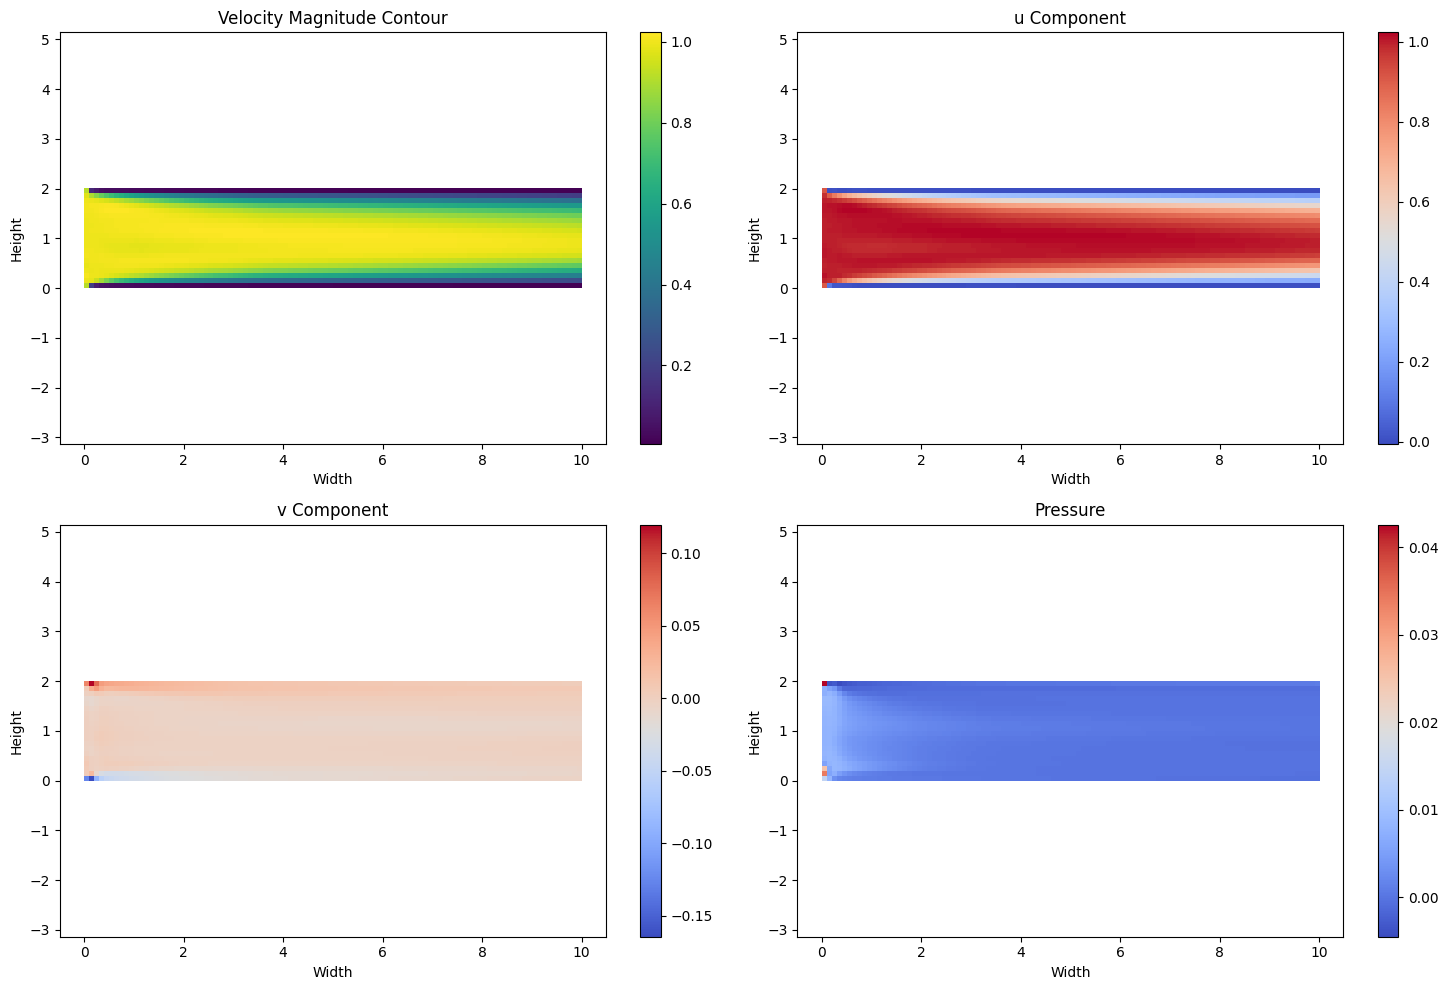

In [22]:
# Extracting predictions
u_pred = model(coordinates)[:, 0].detach().reshape(num_points_x, num_points_y).T
v_pred = model(coordinates)[:, 1].detach().reshape(num_points_x, num_points_y).T
p_pred = model(coordinates)[:, 2].detach().reshape(num_points_x, num_points_y).T

# Velocity Magnitude
magnitude = torch.sqrt(u_pred ** 2 + v_pred ** 2)

# Plotting all subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Velocity Magnitude
im0 = axs[0, 0].imshow(magnitude, extent=(0, width, 0, height), origin='lower', cmap='viridis')
fig.colorbar(im0, ax=axs[0, 0])
axs[0, 0].set_title('Velocity Magnitude Contour')
axs[0, 0].set_xlabel('Width')
axs[0, 0].set_ylabel('Height')
axs[0, 0].axis('equal')

# u Component
im1 = axs[0, 1].imshow(u_pred, extent=(0, width, 0, height), origin='lower', cmap='coolwarm')
fig.colorbar(im1, ax=axs[0, 1])
axs[0, 1].set_title('u Component')
axs[0, 1].set_xlabel('Width')
axs[0, 1].set_ylabel('Height')
axs[0, 1].axis('equal')

# v Component
im2 = axs[1, 0].imshow(v_pred, extent=(0, width, 0, height), origin='lower', cmap='coolwarm')
fig.colorbar(im2, ax=axs[1, 0])
axs[1, 0].set_title('v Component')
axs[1, 0].set_xlabel('Width')
axs[1, 0].set_ylabel('Height')
axs[1, 0].axis('equal')

# Pressure
im3 = axs[1, 1].imshow(p_pred, extent=(0, width, 0, height), origin='lower', cmap='coolwarm')
fig.colorbar(im3, ax=axs[1, 1])
axs[1, 1].set_title('Pressure')
axs[1, 1].set_xlabel('Width')
axs[1, 1].set_ylabel('Height')
axs[1, 1].axis('equal')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

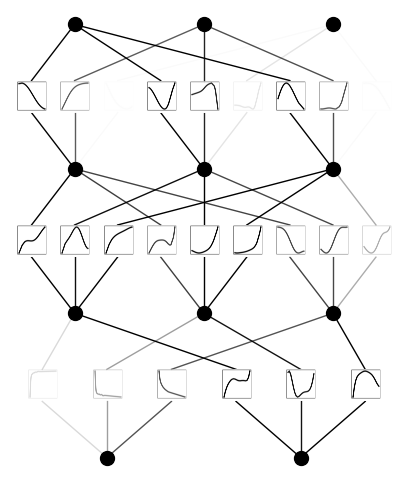

In [23]:
model.plot(beta=10)